# CIFAR10 classification using PyTorch

### Import required packages

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

###  Loading and normalizing CIFAR10
The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Display some images from cifar10 dataset

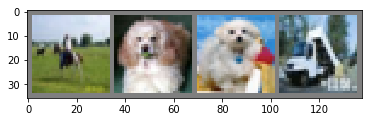

horse   dog   dog truck


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define a Convolutional Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [15]:
# define loss and opti
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 3, 5, 5])


In [26]:
#from livelossplot import PlotLosses
#liveloss = PlotLosses()
#train_losses=[]
for epoch in range(1):  # loop over the dataset multiple times
    logs={}
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        optimizer.zero_grad() #  # zero the parameter gradients
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #running_loss += loss.detach() * inputs.size(0)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
        epoch_loss=running_loss / 2000
print('Finished Training')

[1,  2000] loss: 1.411
[1,  4000] loss: 1.373
[1,  6000] loss: 1.354
[1,  8000] loss: 1.320
[1, 10000] loss: 1.330
[1, 12000] loss: 1.305
Finished Training


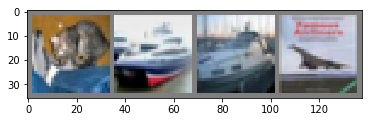

GroundTruth:    cat  ship  ship plane


In [27]:
# test
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [28]:
outputs = net(images)

In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 53 %
Accuracy of   car : 55 %
Accuracy of  bird : 32 %
Accuracy of   cat : 35 %
Accuracy of  deer : 44 %
Accuracy of   dog : 57 %
Accuracy of  frog : 55 %
Accuracy of horse : 54 %
Accuracy of  ship : 66 %
Accuracy of truck : 72 %


### Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
Remember that you will have to send the inputs and targets at every step to the GPU too:

inputs, labels = inputs.to(device), labels.to(device)